# NDES Seminar: Elements of Statistical Learning

## Chapter 2: Overview of Supervised Learning

#### Summer semester 2019, February 28.

(based on https://github.com/dgkim5360/the-elements-of-statistical-learning-notebooks/tree/master/chapter02-overview-of-supervised-learning)
___

What is the goal of supervised learning?

* We have some inputs (X), which we want to use predict values of output(s) (y)

* Resemblance to e.g. OLS regression?

* training data x test data

### Linear models and Least Squares

$$ \widehat{Y} = X^T \widehat{\beta} $$

In [77]:
%matplotlib inline

import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [78]:
def generate_data(sample_size:int)->tuple:
    # Parameters for mean distributions
    mean_blue = [1, 0]
    mean_orange = [0, 1]
    mean_cov = np.eye(2)
    mean_size = 10
    
    # Additional parameters for blue and orange distributions
    sample_cov = np.eye(2)/5
    
    # Generate mean components for blue and orange (10 means for each)
    sample_blue_mean = np.random.multivariate_normal(mean_blue, mean_cov, mean_size)
    sample_orange_mean = np.random.multivariate_normal(mean_orange, mean_cov, mean_size)
    
    # Generate blue points
    sample_blue = np.array([
        np.random.multivariate_normal(sample_blue_mean[random.randint(0, 9)],
                                      sample_cov)
        for _ in range(sample_size)
    ])
    y_blue = [0 for _ in range(sample_size)]

    # Generate orange points
    sample_orange = np.array([
        np.random.multivariate_normal(sample_orange_mean[random.randint(0, 9)],
                                      sample_cov)
        for _ in range(sample_size)
    ])
    y_orange = [1 for _ in range(sample_size)]

    data_x = np.concatenate((sample_blue, sample_orange), axis=0)
    data_y = np.concatenate((y_blue, y_orange))
    return data_x, data_y

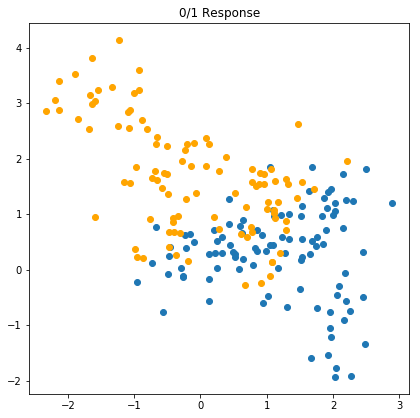

In [79]:
sample_size = 100
data_x, data_y = generate_data(sample_size)
sample_blue = data_x[data_y == 0, :]
sample_orange = data_x[data_y == 1, :]
# Plot
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)

ax1.plot(sample_blue[:, 0], sample_blue[:, 1], 'o')
ax1.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax1.set_title('0/1 Response')
plt.show()

plot_x_min, plot_x_max = ax1.get_xlim()
plot_y_min, plot_y_max = ax1.get_ylim()

In [80]:
# Linear regression
mat_x = np.hstack((np.ones((sample_size*2, 1)), data_x))
mat_xt = np.transpose(mat_x)
vec_y = data_y

# Solve (X^T*X)b = X^T*y for b
ols_beta = np.linalg.solve(np.matmul(mat_xt, mat_x), np.matmul(mat_xt, vec_y))

print('=== Estimated Coefficients for OLS ===')
print('beta0:', ols_beta[0], '(constant)')
print('beta1:', ols_beta[1])
print('beta2:', ols_beta[2])

=== Estimated Coefficients for OLS ===
beta0: 0.37293125015552886 (constant)
beta1: -0.12543514441536516
beta2: 0.19300216779095078


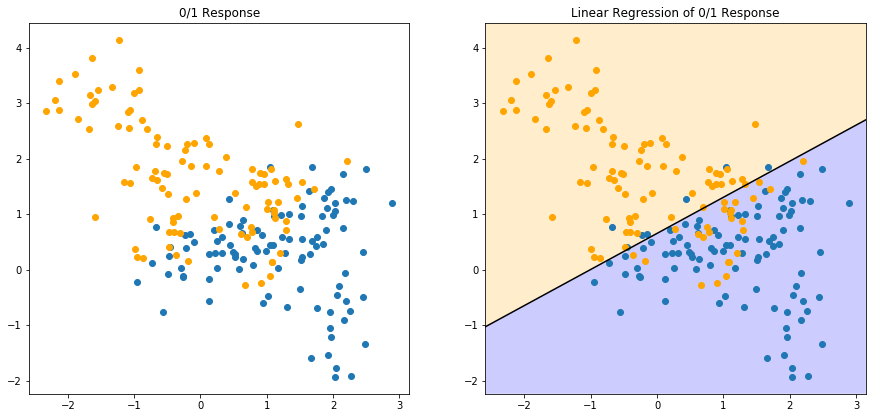

In [81]:
"""FIGURE 2.1. A classification example in 2D."""
# Plot for OLS
ax2 = fig.add_subplot(2, 2, 2)

ax2.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax2.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')

# OLS line for y_hat = 0.5
ols_line_y_min = (.5 - ols_beta[0] - plot_x_min*ols_beta[1])/ols_beta[2]
ols_line_y_max = (.5 - ols_beta[0] - plot_x_max*ols_beta[1])/ols_beta[2]
ax2.plot([plot_x_min, plot_x_max], [ols_line_y_min, ols_line_y_max], color='black')

# https://matplotlib.org/examples/pylab_examples/fill_between_demo.html
ax2.fill_between([plot_x_min, plot_x_max], plot_y_min, [ols_line_y_min, ols_line_y_max],
                facecolor='blue', alpha=.2)
ax2.fill_between([plot_x_min, plot_x_max], [ols_line_y_min, ols_line_y_max], plot_y_max,
                facecolor='orange', alpha=.2)
ax2.set_title('Linear Regression of 0/1 Response')
ax2.set_xlim((plot_x_min, plot_x_max))
ax2.set_ylim((plot_y_min, plot_y_max))
fig

Quite a lot of misclassified points. Are we able to avoid such errors by 'better' model specification? Depends on how the data were generated.

### Nearest-neighbor method

Instead estimate Y using the k closest observations in the input space.

$$ \widehat{Y} = \frac{1}{k} \sum_{x_i \in N_k(x)} y_i$$

In [82]:
# K-nearest neighbors
def knn(k: int, point, data_x, data_y) -> float:
    if not isinstance(point, np.ndarray):
        point = np.array(point)
    distances = [(sum((x - point)**2), y) for x, y in zip(data_x, data_y)]
    distances.sort()
    return sum(y for _, y in distances[:k])/k

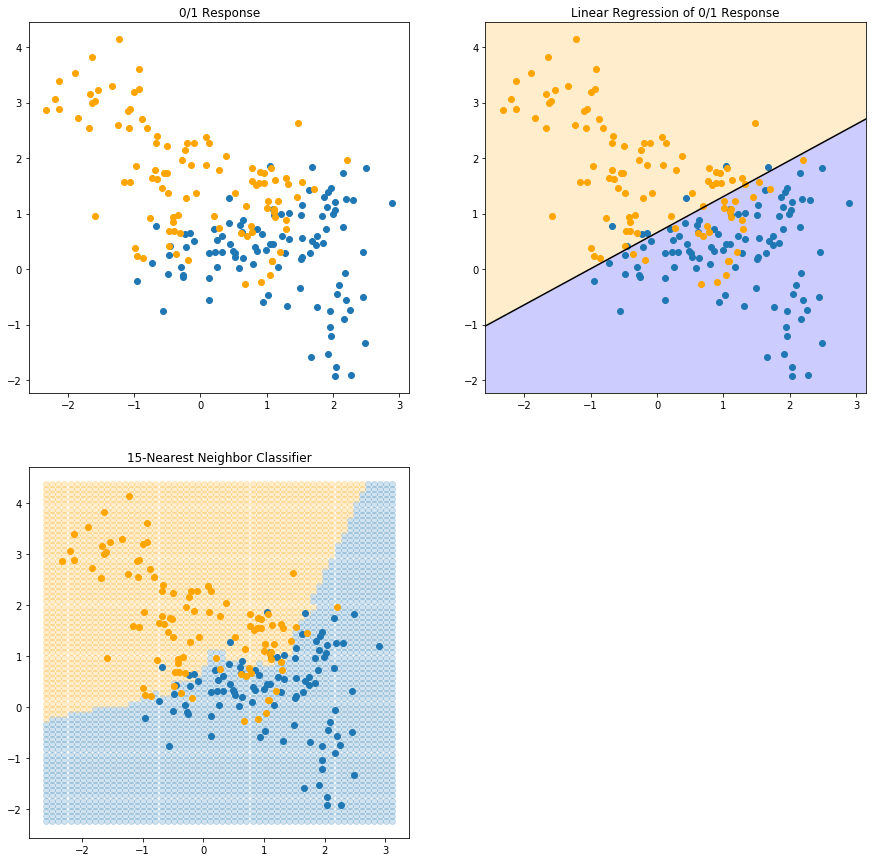

In [83]:
"""FIGURE 2.2. 15-nearest-neighbor method"""
# Compute KNN for k = 15 and k = 1
knn_grid = np.array([(i, j)
                     for i in np.arange(plot_x_min, plot_x_max, .1)
                     for j in np.arange(plot_y_min, plot_y_max, .1)])
knn15_result = np.array([
    (i, j, knn(15, (i, j), data_x, vec_y))
    for i, j in knn_grid
])

# Plot for KNN with k = 15
knn15_blue = np.array([
    (i, j)
    for i, j, knn15 in knn15_result
    if knn15 < .5
])
knn15_orange = np.array([
    (i, j)
    for i, j, knn15 in knn15_result
    if knn15 > .5
])
ax3 = fig.add_subplot(2, 2, 3)
# KNN areas
ax3.plot(knn15_blue[:, 0], knn15_blue[:, 1], 'o', alpha=.2)
ax3.plot(knn15_orange[:, 0], knn15_orange[:, 1], 'o', color='orange', alpha=.2)
# Original data
ax3.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax3.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax3.set_title('15-Nearest Neighbor Classifier')
fig

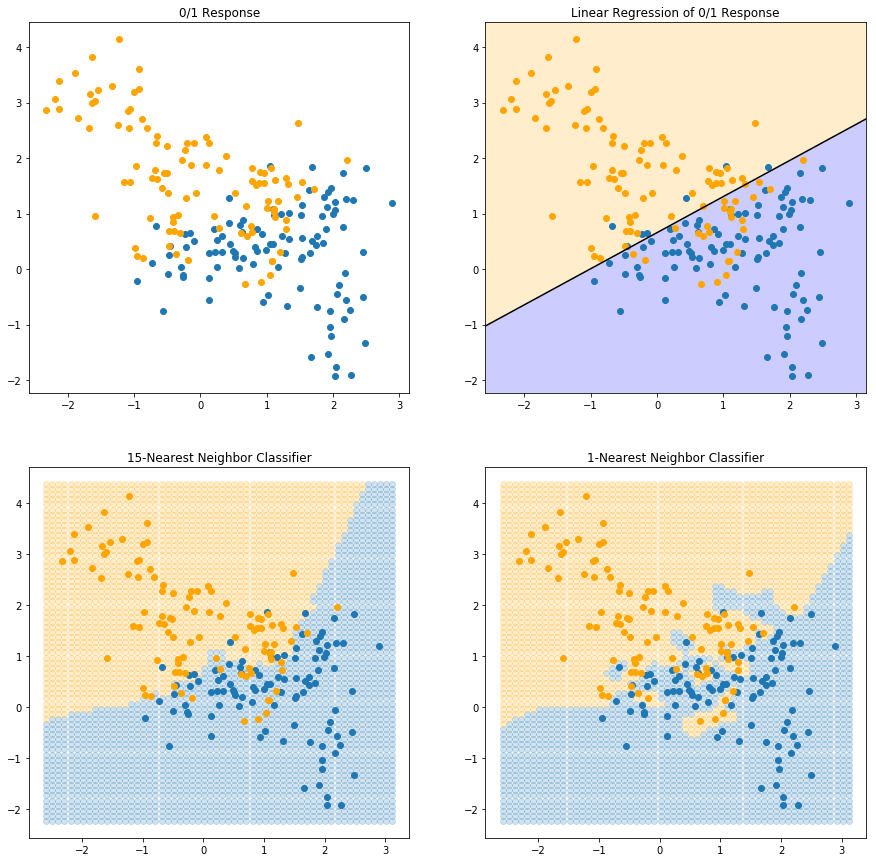

In [84]:
"""FIGURE 2.3. 1-nearest-neighbor method"""
# Compute KNN for k = 15 and k = 1
knn1_result = np.array([
    (i, j, knn(1, (i, j), data_x, vec_y))
    for i, j in knn_grid
])

knn1_blue = np.array([
    (i, j)
    for i, j, knn1 in knn1_result
    if knn1 < .5
])
knn1_orange = np.array([
    (i, j)
    for i, j, knn1 in knn1_result
    if knn1 > .5
])

# Plot for KNN with k = 1
ax4 = fig.add_subplot(2, 2, 4)
# KNN areas
ax4.plot(knn1_blue[:, 0], knn1_blue[:, 1], 'o', alpha=.2)
ax4.plot(knn1_orange[:, 0], knn1_orange[:, 1], 'o', color='orange', alpha=.2)
# Original data
ax4.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax4.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='orange')
ax4.set_title('1-Nearest Neighbor Classifier')
fig

No misclassifications in the last model. Does it mean we should use it?

How about the number of parameters we fit?

* Linear decision boundary smooth and stable to fit
    * relies on assumption that linear boundary is appropriate
* Nearest-neighbors more adaptible, but quite unstable

There is a bias-variance trade-off when we select between these two cases

## 2.4 Statistical decision theory

Let
* $X\in\mathbb{R}^p$ denote a real valued random input vector, and
* $Y\in\mathbb{R}$ a real valued random output variable,
* with joint distribution $\text{Pr}(X,Y)$.

To be able to find function f(X) predicting Y, we need loss function $L(Y, f(X))$ for penalizing errors in prediciton. Most commonly used and convenient is _squared error loss_:

\begin{equation}
L(Y, f(X)) = (Y-f(X))^2.
\end{equation}

The loss function gives us a criterion for finding f(X): 

\begin{align}
\text{EPE}(f) &= \text{E}(Y-f(X))^2\\
&= \int\left(y-f(x)\right)^2\text{Pr}(dx,dy),
\end{align}

We can show the solution is the conditional expectation a.k.a. the _regression_ function:

\begin{equation}
f(x) = \text{E}\left(Y|X=x\right)
\end{equation}

> Thus the best prediction of $Y$ at any point $X=x$ is the conditional mean, when best is measured by average squared error.

That notion is directly implemented by k Nearest-Neighbors using two approximations:

* Expectation is approximated by averaging over sample data;
* conditioning at a point is relaxed to conditioning on some region "close" to the target point.

Under mild regularity conditions on the joint probability distribution $\text{Pr}(X,Y)$, one can show that

\begin{equation}
\hat{f}(x)\rightarrow\text{E}(Y|X=x)\text{ as }N,k\rightarrow\infty\text{ s.t. }k/N\rightarrow0
\end{equation}

**Perfect right?**

Problems:

* We often do not have very large samples.  
  Linear models can usually get a more stable estimate than kNN, provided the structured model is appropriate (although such knowledge has to be learned from the data as well).
* Curse of dimensionality.  
  As the dimension $p$ gets large, so does the metric size of the $k$-nearest neighborhood. So settling for kNN as a surrogate for conditioning will fail us miserably.  
  The convergence above still holds, but the _rate_ of convergence decreases as the dimension increases.

### kNN vs. least squares

So both kNN and least squares end up approximating conditional expectations by averages. But they differ dramatically in terms of model assumptions:
* Least squares assumes $f(x)$ is well approximated by a globally linear function.
* kNN assumes $f(x)$ is well approximated by a locally constant function.

Although the latter seems more palatable, we have already seen that we may pay a price for this flexibility.

### Additive models (Brief on modern techniques)

Many of the more modern techniques described in this book are model based, although far more flexible than the rigid linear model.

\begin{equation}
f(X) = \sum_{j=1}^p f_j(X_j).
\end{equation}

Thus the problems of estimating a conditional expectation in high dimensions are swept away in this case by imposing some (often unrealistic) model assumptions, in this case additivity.

### Bayes classifier: For a categorical output with 0-1 loss function

We need a different loss function for penalizing prediction errors when working with categorcial variables.

Our loss function can be represented by $K\times K$ matrix $\mathbf{L}$, where $K=\text{card}(\mathcal{G})$. $\mathbf{L}$ will be zero on the diagonal and nonnegative elsewhere, representing the price paid for misclassifying $\mathcal{G}_k$ as $\mathcal{G}_l$;

\begin{equation}
\mathbf{L} = \begin{bmatrix}
0 & L(\mathcal{G}_1, \mathcal{G}_2) & \cdots & L(\mathcal{G}_1, \mathcal{G}_K) \\
L(\mathcal{G}_2, \mathcal{G}_1) & 0 & \cdots & L(\mathcal{G}_2, \mathcal{G}_K) \\
\vdots & \vdots & \ddots & \vdots \\
L(\mathcal{G}_K, \mathcal{G}_1) & L(\mathcal{G}_K, \mathcal{G}_2) & \cdots & 0
\end{bmatrix}
\end{equation}

The expected prediction error is

\begin{equation}
\text{EPE} = \text{E}\left[L(G, \hat{G}(X)\right],
\end{equation}

where the expectation is taken w.r.t. the joint distribution $\text{Pr}(G, X)$.

Again we condition, and can write EPE as

\begin{equation}
\text{EPE} = \text{E}_X\sum^K_{k=1}L\left(\mathcal{G}_k, \hat{G}(X)\right)\text{Pr}\left(\mathcal{G}_k|X\right)
\end{equation}

and again it suffices to minimize EPE pointwise:

\begin{equation}
\hat{G}(x) = \arg\min_{g\in\mathcal{G}}\sum^K_{k=1} L\left(\mathcal{G}_k,g\right)\text{Pr}\left(\mathcal{G}_k|X=x\right)
\end{equation}

#### 0-1 loss for Bayes classifier

Most often we use the _zero-one_ loss function, where all misclassifications are charged a single unit, i.e.,

\begin{equation}
L(k,l) = \begin{cases}
0\text{ if }k = l,\\
1\text{ otherwise}.
\end{cases}
\end{equation}

With the 0-1 loss function this simplifies to

\begin{align}
\hat{G}(x) &= \arg\min_{g\in\mathcal{G}} \left[1 - \text{Pr}(g|X=x)\right]\\
&= \mathcal{G}_k \text{ if Pr}\left(\mathcal{G}_k|X=x\right) = \max_{g\in\mathcal{G}}\text{Pr}(g|X=x)
\end{align}

This reasonable solution is known as the _Bayes classifier_, and says that we classify to the most probable class, using the conditional (discrete) distribution $\text{Pr}(G|X)$. FIGURE 2.5 shows the Bayes-optimal decision boundary for our simulation example. The error rate of the Bayes classifier is called the _Bayes rate_.

In [56]:
%matplotlib inline
import random
import scipy
import scipy.stats
import matplotlib.pyplot as plt

In [57]:
"""FIGURE 2.5. The optimal Bayes decision boundary for the simulation example.
Since the generating density is known for each class, this decision boundary can be
calculated exactly."""
sample_size = 100
# Parameters for mean distributions
mean_blue = [1, 0]
mean_orange = [0, 1]
mean_cov = scipy.eye(2)
mean_size = 10

# Additional parameters for blue and orange distributions
sample_cov = scipy.eye(2)/5

# Generate mean components for blue and orange (10 means for each)
sample_blue_mean = scipy.random.multivariate_normal(mean_blue, mean_cov, mean_size)
sample_orange_mean = scipy.random.multivariate_normal(mean_orange, mean_cov, mean_size)

# Generate blue points
sample_blue = scipy.array([
    scipy.random.multivariate_normal(sample_blue_mean[r], sample_cov)
    for r in scipy.random.randint(0, 10, 100)
])
y_blue = scipy.zeros(sample_size)

# Generate orange points
sample_orange = scipy.array([
    scipy.random.multivariate_normal(sample_orange_mean[r], sample_cov)
    for r in scipy.random.randint(0, 10, 100)
])
y_orange = scipy.ones(sample_size)

data_x = scipy.concatenate((sample_blue, sample_orange), axis=0)
data_y = scipy.concatenate((y_blue, y_orange)) 

In [58]:
def density_blue(arr:scipy.ndarray)->scipy.ndarray:
    densities = scipy.array([
        scipy.stats.multivariate_normal.pdf(arr, mean=m, cov=mean_cov)
        for m in sample_blue_mean
    ])
    return densities.mean(axis=0)


def density_orange(arr:scipy.ndarray)->scipy.ndarray:
    densities = scipy.array([
        scipy.stats.multivariate_normal.pdf(arr, mean=m, cov=mean_cov)
        for m in sample_orange_mean
    ])
    return densities.mean(axis=0)

In [59]:
min_x = data_x.min(axis=0)
max_x = data_x.max(axis=0)
print(min_x, max_x)
arr = scipy.array([(i, j)
                   for i in scipy.linspace(min_x[0]-.1, max_x[0]+.1, 100)
                   for j in scipy.linspace(min_x[1]-.1, max_x[1]+.1, 100)])
proba_blue = density_blue(arr)
proba_orange = density_orange(arr)

[-1.87509181 -2.04290537] [3.25210384 3.7280058 ]


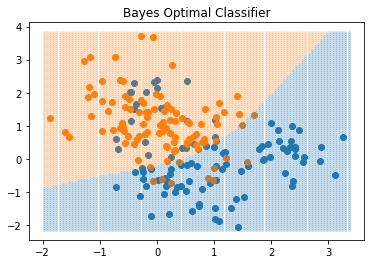

In [60]:
# Plot
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
# Original data
ax.plot(sample_blue[:, 0], sample_blue[:, 1], 'o', color='C0')
ax.plot(sample_orange[:, 0], sample_orange[:, 1], 'o', color='C1')
# Bayes classifier
mask_blue = proba_blue > proba_orange
mask_orange = ~mask_blue
ax.plot(arr[mask_blue, 0], arr[mask_blue, 1], 'o',
        markersize=2, color='C0', alpha=.2)
ax.plot(arr[mask_orange, 0], arr[mask_orange, 1], 'o',
        markersize=2, color='C1', alpha=.2)
ax.set_title('Bayes Optimal Classifier')
plt.show()

### KNN and Bayes classifier

Again we see that the kNN classifier directly approximates this solution -- a majority vote in a nearest neighborhood amounts to exactly this, except that
* conditional probability at a point is relaxed to conditional probability within a neighborhood of a point,
* and probabilities are estimated by training-sample proportions.

## Local methods in high dimensions

It would seem that with a reasonably large set of training data, we could always approximate the theoretically optimal conditional expectation by kNN averaging, since we should be able to find a fairly large neighborhood of observations close to any $x$ and average them.

This intuition breaks down in high dimensions, and the phenomenon is commonly referred to as the **curse of dimensionality** (Bellman, 1961).

### Unit hypercube

Consider the nearest-neighbor procedure for inputs uniformly distributed in a p-dimensional unit hypercube. Suppose we send out a hypercubical neighborhood about a target point to capture a fraction $r$ of the observations. Since this corresponds to a fraction $r$ of the unit volume, the expected edge length will be 

\begin{equation}
e_p(r) = r^{1/p}.
\end{equation}

Note that $e_{10}(.01) = 0.63$ and $e_{10}(.1) = .80$, while the entire range for each input is only 1.0. Soto capture 1% or 10% of the data to form a local average, we must cover 63% or 80% of the range of each input variable. Such neighborhoods are no longer "local".

Reducing $r$ dramatically does not help much either, since the fewer observations we average, the higher is the variance of our fit.

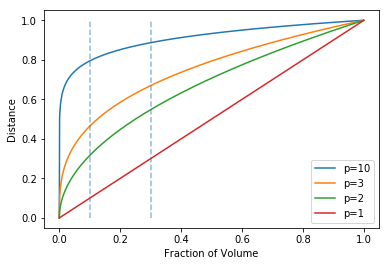

In [63]:
"""FIGURE 2.6. (right panel) The unit hypercube example"""
fraction_of_volume = np.arange(0, 1, 0.001)
edge_length_p1 = fraction_of_volume
edge_length_p2 = fraction_of_volume**.5
edge_length_p3 = fraction_of_volume**(1/3)
edge_length_p10 = fraction_of_volume**.1

fig1 = plt.figure(1)
ax11 = fig1.add_subplot(1, 1, 1)
ax11.plot(fraction_of_volume, edge_length_p10, label='p=10')
ax11.plot(fraction_of_volume, edge_length_p3, label='p=3')
ax11.plot(fraction_of_volume, edge_length_p2, label='p=2')
ax11.plot(fraction_of_volume, edge_length_p1, label='p=1')
ax11.set_xlabel('Fraction of Volume')
ax11.set_ylabel('Distance')
ax11.legend()
ax11.plot([.1, .1], [0, 1], '--', color='C0', alpha=.5)
ax11.plot([.3, .3], [0, 1], '--', color='C0', alpha=.5)
plt.show()

### The second example: Unit ball

In high dimensions all sample points are close to an edge of the sample.

Consider $N$ data points uniformly distributed in a $p$-dimensional unit ball centered at the origin. And consider a nearest-neighbor estimate at the origin. The median distance from the orign to the closest data point is given by the expression.

\begin{equation}
d(p,N) = \left(1-\frac{1}{2}^{1/N}\right)^{1/p}.
\end{equation}

For $N=500, p=10$, $d(p,N)\approx0.52$, more than half way to the boundary. Hence most data points are close to the boundary of the sample space than to any other data point.

**Problem?** 

Yes, because prediction is much more difficult near the edges of the training sample. One must extrapolate from neighboring sample points rather than interpolate between them.

Another manifestiation of the curse is that the sampling density is proportional to $N^{1/p}$.

If $N_1=100$ represents a dense sample for a single input problem, then $N_{10}=100^{10}$ is the sample size required for the same sampling density with 10 inputs.

### Bias-variance decomposition

Let us construct another uniform example. Suppose
* we have 1000 training examples $x_i$ generated uniformly on $[-1,1]^p$, and
* the true relationship between $X$ and $Y$ is  

  \begin{equation}
  Y = f(X) = e^{-8\|X\|^2},
  \end{equation}
  
  without any measurement error.
* We use the 1NN rule to predict $y_0$ at the test-point $x_0=0$.

Denote the training set by $\mathcal{T}$. We can compute the expected prediction error at $x_0$ for our procedure, averaging over all such samples of size 1000. Since the problem is deterministic, this is the mean squared error (MSE) for estimating $f(0)$.

\begin{align}
\text{MSE}(x_0) &= \text{E}_\mathcal{T}\left[f(x_0)-\hat{y}_0\right]^2 \\
&= \text{E}_\mathcal{T}\left[f(x_0) -\text{E}_\mathcal{T}(\hat{y}_0) + \text{E}_\mathcal{T}(\hat{y}_0)-\hat{y}_0\right]^2 \\
&= \text{E}_\mathcal{T}\left[\hat{y}_0 - \text{E}_\mathcal{T}(\hat{y}_0)\right]^2 + \left[\text{E}_\mathcal{T}(\hat{y}_0)-f(x_0)\right]^2 + 2\left[\text{E}_\mathcal{T}(\hat{y}_0)-f(x_0)\right]\text{E}_\mathcal{T}\left[\hat{y}_0 - \text{E}_\mathcal{T}(\hat{y}_0)\right]\\
&= \text{E}_\mathcal{T}\left[\hat{y}_0 - \text{E}_\mathcal{T}(\hat{y}_0)\right]^2 + \left[\text{E}_\mathcal{T}(\hat{y}_0)-f(x_0)\right]^2 \\
&= \text{Var}_\mathcal{T}(\hat{y}_0) + \text{Bias}^2(\hat{y}_0)
\end{align}

We have broken down the MSE into two components that will become familiar as we proceed: Variance and squared bias. Such a decomposition is always possible and often useful, and is known as the _bias-variance decomposition_.

In [66]:
"""FIGURE 2.7. (bottom panels) Bias-variance decomposition example.
Given the dimension p, 100 simulations are done and the following steps are
taken for each simulation.
1. Generate data of size 1000 from [-1, 1]^p
2. Grap the nearest neighbor x of 0 and calculate the distance, i.e., norm
3. Calculate y=f(x) and the variance and the squared bias for simulation
of size 100.
"""
def generate_data(p: int, n: int) ->np.ndarray:
    if p == 1:
        return np.array([random.uniform(-1, 1) for _ in range(n)])
    return np.array([
        [random.uniform(-1, 1) for _ in range(p)]
        for _ in range(n)
    ])


def f(p: int, x: np.ndarray) ->float:
    if p == 1:
        return math.exp(-8*(x**2))
    return math.exp(-8*sum(xi*xi for xi in x))


def simulate(p: int, nsample:int, nsim: int) ->dict:
    res = {'average_distance': 0}
    sum_y = 0
    sum_y_square = 0
    for _ in range(nsim):
        data = generate_data(p, nsample)
        if p == 1:
            data_norm = np.abs(data)
        else:
            data_norm = np.linalg.norm(data, ord=2, axis=1)
        nearest_index = data_norm.argmin()
        nearest_x, nearest_distance = data[nearest_index], data_norm[nearest_index]
        nearest_y = f(p, nearest_x)
        sum_y += nearest_y
        sum_y_square += nearest_y*nearest_y
        res['average_distance'] += nearest_distance
    average_y = sum_y/nsim
    res['average_distance'] /= nsim
    res['variance'] = sum_y_square/nsim - average_y*average_y
    res['squared_bias'] = (1-average_y)*(1-average_y)
    return res

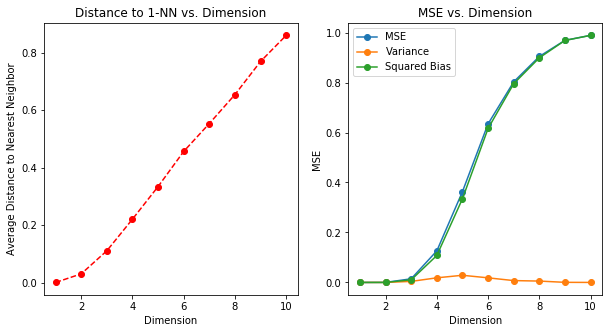

In [69]:
nsim = 100
data = {p: simulate(p, 1000, nsim) for p in range(1, 11)}
dimension = list(data.keys())
average_distance = [d['average_distance'] for p, d in data.items()]
variance = np.array([d['variance'] for p, d in data.items()])
squared_bias = np.array([d['squared_bias'] for p, d in data.items()])
mse = variance + squared_bias

fig2 = plt.figure(2, figsize=(10, 5))
ax21 = fig2.add_subplot(1, 2, 1)
ax21.set_title('Distance to 1-NN vs. Dimension')
ax21.plot(dimension, average_distance, 'ro--')
ax21.set_xlabel('Dimension')
ax21.set_ylabel('Average Distance to Nearest Neighbor')

ax22 = fig2.add_subplot(1, 2, 2)
ax22.set_title('MSE vs. Dimension')
ax22.plot(dimension, mse, 'o-', label='MSE')
ax22.plot(dimension, variance, 'o-', label='Variance')
ax22.plot(dimension, squared_bias, 'o-', label='Squared Bias')
ax22.set_xlabel('Dimension')
ax22.set_ylabel('MSE')
ax22.legend()
plt.show()

In low dimensions and with $N = 1000$, the nearest neighbor is very close to $0$, and so both the bias and variance are small. As the dimension increases, the nearest neighbor tends to stray further from the target point, and both bias and variance are incurred. By $p = 10$, for more than $99\%$ of the samples the nearest neighbor is a distance greater than $0.5$ from the origin.

Thus as $p$ increases, the estimate tends to be 0 more often than not, and hence the MSE levels off at 1.0, as does the bias, and the variance starts dropping (an artifact of this example).

### Linear relationship

> By imposing some heavy restrictions on the class of models being fitted, we can avoid the curse of dimensionality.

Suppose the relationship between $Y$ and $X$ is linear,

\begin{equation}
Y=X^T\beta+\epsilon,
\end{equation}

where $\epsilon\sim N(0,\sigma^2)$.

Since under this model the least squares estimates are unbiased, we find that

\begin{align}
\text{EPE}(x_0) &= \text{E}_{y_0|x_0}\text{E}_\mathcal{T}\left(y_0-\hat{y}_0\right)^2 \\
&= \text{Var}(y_0|x_0) + \text{E}_\mathcal{T} \left(\hat{y}_0 - \text{E}_\mathcal{T}\hat{y}_0\right)^2 + \left(\text{E}_\mathcal{T}\hat{y}_0 - x_0^T\beta\right)^2 \\
&= \text{Var}(y_0|x_0) + \text{Var}_\mathcal{T}(\hat{y}_0) + \text{Bias}^2(\hat{y}_0) \\
&= \sigma^2 + \text{E}_\mathcal{T}x_0^T\left(\mathbf{X}^T\mathbf{X}\right)^{-1}x_0\sigma^2 + 0^2.
\end{align}

Note that
1. An additional variance $\sigma^2$ is incurred, since our target is not deterministic.
2. There is no bias, and the variance depends on $x_0$.

If
* $N$ is large,
* $\mathcal{T}$ were selected at random, and
* $\text{E}(X)=0$,

then $\mathbf{X}^T\mathbf{X}\rightarrow N\text{Cov}(X)$ and

\begin{align}
\text{E}_{x_0}\text{EPE}(x_0) &\sim \text{E}_{x_0}x_0^T\text{Cov}(X)^{-1}x_0\sigma^2/N + \sigma^2 \\
&= \text{trace}\left(\text{Cov}(X)^{-1}\text{Cov}(x_0)\right)\sigma^2/N + \sigma^2 \\
&= \sigma^2(p/N)+\sigma^2.
\end{align}

The expected EPE increases linearly as a function of $p$, with slope $\sigma^2/N$. If $N$ is large and/or $\sigma^2$ is small, this growth is variance is negligible (0 in the deterministic case).

By imposing some heavy restrictions on the class of models being fitted, we have avoided the curse of dimensionality. Some of the technical details are derived in Exercise 2.5.

### EPE comparison: 1NN vs. least squares

FIGURE 2.9 compares 1NN vs. least squares in two situations, both of which have the form

\begin{equation}
Y = f(X) + \epsilon,
\end{equation}

* $X$ uniform as before,
* $\epsilon \sim N(0,1)$,
* $N=500$.

For the orange curve, $f(x) = x_1$ is linear in the first coordinate, for the blue curve, $f(x) = \frac{1}{2}(x_1+1)^3$ is cubic as in the figure.

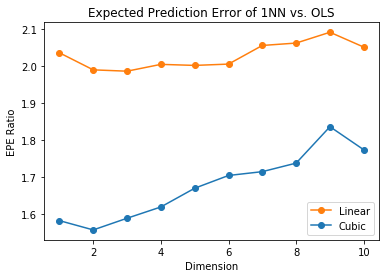

In [70]:
"""FIGURE 2.9. Relative EPE (at x_0 = 0) ratio for 1NN vs. least squares"""
size_simulation = 10000
size_train = 500
p = 10

list_epe_ols_linear = []
list_epe_1nn_linear = []
list_epe_ols_cubic = []
list_epe_1nn_cubic = []

for _ in range(size_simulation):
    epe_linear = []
    # Generate data
    train_x = np.random.uniform(-1, 1, size=(size_train, p))
    train_y_linear = train_x[:, 0]
    train_y_cubic = ((train_x[:, 0]+1)**3)/2
    train_error = np.random.randn(size_train)
    train_ye_linear = train_y_linear + train_error
    train_ye_cubic = train_y_cubic + train_error
    
    epe_ols_linear = []
    epe_1nn_linear = []
    epe_ols_cubic = []
    epe_1nn_cubic = []
    for dim in range(1, p+1):
        # Cut the dimension
        partial_x = train_x[:, :dim]
        partial_1x = np.hstack((np.ones((size_train, 1)), partial_x))
        
        obs_y_linear = np.random.randn(1)
        obs_y_cubic = .5 + np.random.randn(1)

        # Least squares for linear f
        xx = partial_1x.T @ partial_1x
        xy_linear = partial_1x.T @ train_ye_linear
        xxxy_linear = np.linalg.solve(xx, xy_linear)
        hat_ols = np.array([1] + [0]*dim) @ xxxy_linear
        epe_ols_linear.append((hat_ols-obs_y_linear)**2)

        # 1NN for linear f
        mat_norm = (partial_x*partial_x).sum(axis=1)
        nn = mat_norm.argmin()
        hat_1nn = train_ye_linear[nn]
        epe_1nn_linear.append((hat_1nn-obs_y_linear)**2)
        
        # Least squares for cubic f
        xy_cubic = partial_1x.T @ train_ye_cubic
        xxxy_cubic = np.linalg.solve(xx, xy_cubic)
        hat_ols = np.array([1] + [0]*dim) @ xxxy_cubic
        epe_ols_cubic.append((hat_ols-obs_y_cubic)**2)
        
        # 1NN for cubic f
        hat_1nn = train_ye_cubic[nn]
        epe_1nn_cubic.append((hat_1nn-obs_y_cubic)**2)

    list_epe_ols_linear.append(epe_ols_linear)
    list_epe_1nn_linear.append(epe_1nn_linear)
    list_epe_ols_cubic.append(epe_ols_cubic)
    list_epe_1nn_cubic.append(epe_1nn_cubic)

arr_epe_ols_linear = np.array(list_epe_ols_linear)
arr_epe_1nn_linear = np.array(list_epe_1nn_linear)
arr_epe_ols_cubic = np.array(list_epe_ols_cubic)
arr_epe_1nn_cubic = np.array(list_epe_1nn_cubic)

# Compute EPE, finally
epe_ols_linear = arr_epe_ols_linear.mean(axis=0)
epe_1nn_linear = arr_epe_1nn_linear.mean(axis=0)
epe_ols_cubic = arr_epe_ols_cubic.mean(axis=0)
epe_1nn_cubic = arr_epe_1nn_cubic.mean(axis=0)

# Plot
plot_x = list(range(1, p+1))
fig4 = plt.figure(4)
ax41 = fig4.add_subplot(1, 1, 1)
ax41.plot(plot_x, epe_1nn_linear/epe_ols_linear, '-o',
          color='C1', label='Linear')
ax41.plot(plot_x, epe_1nn_cubic/epe_ols_cubic, '-o',
          color='C0', label='Cubic')
ax41.legend()
ax41.set_xlabel('Dimension')
ax41.set_ylabel('EPE Ratio')
ax41.set_title('Expected Prediction Error of 1NN vs. OLS')
plt.show()

> By relying on rigid assumptions, the linear model has no bias at all and negligible variance, while the error in 1-nearest neighbor is substantially larger. However, if the assumptions are wrong, all bets are off and the 1-nearest neighbor may dominate. We will see that there is a whole spectrum of models between the rigid linear models and the extremely flexible 1-nearest-neighbor models, each with their own assumptions and biases, which have been proposed specifically to avoid the exponential growth in complexity of functions in high dimensions by drawing heavily on these assumptions.

## Statistical models, supervised learning, and function aproximation

Our goal is to find a useful approximation $\hat{f}(x)$ to $f(x)$ that underlies the predictive relationship between the inputs and outputs.

1. For a quantitative response, squared error loss lead us to the regression function.

2. The kNNs can be viewed as direct estimates of this conditional expectation, but they can fail in two ways

 * If the dimension of the input space is high, the nearest neighbors need not be close to the target point, and can result in large errors,
  * if special structure is known to exist, this can be used to reduce both the bias and the variance of the estimates.
  
> We anticipate using other classes of models for $f(x)$, in many cases specifically designed to overcome the dimensionality problems, and here we discuss a framework for incorporating them into the prediction problem.

### The additive error model
Suppose in fact that our data arose from a statistical model

\begin{equation}
Y = f(X) + \epsilon,
\end{equation}

where the random error $\epsilon$ has $\text{E}(\epsilon)=0$ and is independent of $X$.

The additive error model is a useful approximation to the truth. For most systems the input-output pairs $(X,Y)$ will not have a deterministic relationship $Y=f(X)$. Generally there will be other unmeasured variables that also contribute to $Y$, including measurement error. The additive model assumes that we can capture all these departures from a deterministic relationship via the error $\epsilon$.

### The i.i.d. assumption

The assumption in the above additive error model that the errors are i.i.d. is not strictly necessary, but seems to be the back of our mind when we average squared errors uniformly in our EPE criterion. Simple modifications can be made to avoid the independence assumption.

### Qualitative models

Additive error models are typically not used for qualitative outputs $G$; in this case the target function $p(X)$ _is_ the conditional density $\text{Pr}(G|X)$, and this is modeled directly.

For example, for two-class data, it is often reasonable to assume that the data arise from independent binary trials, with the probability of one particular outcome being $p(X)$, and the other $1 − p(X)$. Thus if $Y$ is the 0–1 coded version of $G$, then
\begin{equation}
\text{E}(Y |X = x) = p(x),
\end{equation}

but the variance depends on $x$ as well: $\text{Var}(Y |X = x) = p(x)\left(1 − p(x)\right)$.

## Supervised learning and Function aproximation

Suppose for simplicity the additive error model

\begin{equation}
Y = f(X) + \epsilon
\end{equation}

is a reasonable assumption.

The learning algorithm has the property that it can modify its input/output relationship $\hat{f}$ in response to differences $y_i − \hat{f}(x_i)$ between the original and generated outputs.

Here
* the data pairs $\{x_i, y_i\}$ are viewed as points in a $(p+1)$-dimensional Euclidean space.
* The function $f(x)$ has domain eqaul to the $p$-dimensional input subspace (or $\mathbb{R}^p$ for convenience), and
* $f$ is related to the data via a model such as $y_i=f(x_i)+\epsilon$.

The goal is to obtain a useful approximation to $f(x)$ for all $x$ in some region of $\mathbb{R}^p$, given the representations in $\mathcal{T}$.

> Although somewhat less glamorous than the learning paradigm, treating supervised learning as a problem in function approximation encourages the geometrical concepts of Euclidean spaces and mathematical concepts of probabilsitic inference to be applied to the problem. This is the approach taken in this book.

### Associated parameters and basis expansions

Many of the approximations we will encounter have associated a set of parameters $\theta$ that can be modified to suit the data at hand. For example, the linear model

\begin{equation}
f(x) = x^T\beta
\end{equation}

has $\theta=\beta$.

Another class of useful approximators can be expressed as _linear basis expansions_
\begin{equation}
f_\theta(x) = \sum_{k=1}^K h_k(x)\theta_k,
\end{equation}
where the $h_k$ are a suitable set of functions or transformations of the input vector $x$. Traditional examples are polynomial and trigonometric expansions, where for example $h_k$ might be $x_1^2$, $x_1x_2^2$, $\text{cos}(x_1)$ and so on.

### Least squares again
We can use least squares to estimate the parameters $\theta$ in $f_\theta$ as we did for the linear model, by minimizing the residual sum-of-squares
\begin{equation}
\text{RSS}(\theta) = \sum_{i=1}^N\left(y_i-f_\theta(x_i)\right)^2
\end{equation}
as a function of $\theta$. This seems a reasonable criterion for an additive error model.

For the linear model we get a simple closed form solution to the minimization problem. This is also true for the basis function methods, if the basis functions themselves do not have any hidden parameters. Otherwise the solution requires either iterative methods or numerical optimization.

### Maximum likelihood estimation

Suppose we have a random sample $y_i, i=1,\cdots,N$ from a density $\text{Pr}_\theta(y)$ indexed by some parameters $\theta$. The log-probability of the observed sample is

\begin{equation}
L(\theta) = \sum_{i=1}^N\log\text{Pr}_\theta(y_i).
\end{equation}

> The principle of maximum likelihood assumes that the most reasonable values for $\theta$ are those for which the probability of the observed sample is largest.

## Structured regression models

Often, it is appropriate or more efficient to use more structured models than nearest-neighbors or other local methods.

Consider the RSS criterion for an arbitrary function $f$,

\begin{equation}
\text{RSS}(f) = \sum_{i=1}^N \left( y_i - f(x_i) \right)^2.
\end{equation}

Minimizing the RSS leads to infinitely many solutions: Any function $\hat{f}$ passing through the training points $(x_i,y_i)$ is a solution. Any particular solution chosen might be a poor predictor at test points different from the training points.

If the sample size $N$ were sufficiently large such that repeats were guaranteed and densely arranged, it would seem that these solutions might all tend to the limiting conditional expectation.

In order to obtain useful results for finite $N$, we must restrict the eligible solution to the RSS to a smaller set of functions.

> How to decide on the nature of the restrictions is based on considerations outside of the data.

These restrictions are somtimes
* encoded via the parametric representation of $f_\theta$, or
* may be built into the learning method itself, either implicitly or explicitly.

> Any restrictions imposed on $f$ that lead to a unique solution to RSS do not really remove the ambiguity caused by the multiplicity of solutions. There are infinitely many possible restrictions, each leading to a unique solution, so the abmiguity has simply been transferred to the choice of constraint.

#### Complexity restrictions

In general the constraints imposed by most learning methods can be described as _complexity_ restrictions of one kind or another.

> This usually means some kind of regular behavior in small neighborhoods of the input space.

That is, for all input points $x$ sufficiently close to each other in some metric, $\hat{f}$ exhibits some special structure such as
* nearly constant,
* linear or
* low-order polynomial behavior.

The strength of the constraint is dictated by the neighborhood size.

> The larger the size, the stronger the constraint, and the more sensitive the solution is to the particular choice of constraint.

### Curse of dimensionality again

One fact should be clear by now. Any method that attempts to produce locally varying functions in small isotopic neighborhoods will run into problems in high dimensions -- again the curse of dimensionality.

And conversely, all methods that overcome the dimensionality problems have an associated -- and often implicit or adaptive -- metric for measuring neighborhoods, which basically does not allow the neighborhood to be simultaneously small in all directions.

## Classes of restricted estimators

Nonparametric regression techniques or learning methods fall into a number of different classes depending on the nature of the restrictions imposed. These classes are not distinct, and indeed some methods fall in several classes.

Each of the classes has associated with it one or more parameters, sometimes appropriately called _smoonthing_ parameters, that control the effective size of the local neighborhood.

## 2.8.1. Roughness Penalty and Bayesian Methods

Here the class of functions is controlled by explicitly penalizing $\text{RSS}(f)$ with a roughness penalty $J$

\begin{equation}
\text{PRSS}(f;\lambda) = \text{RSS}(f) + \lambda J(f),
\end{equation}

where the user-selected functional $J(f)$ will be large for functions $f$ that vary too rapidly over small regions of input space.

Penalty function, or _regularization_ methods, express our prior belief that the type of functions we seek exhibits a certain type of smooth behavior, and indeed can usually be cast in a Bayesian framework.

## 2.8.2. Kernel Methods and Local Regression

These methods can be thought of as explicitly providing estimates of the regression function or conditional expectation by specifying the nature of the local neighborhood, and of the class of regular functions fitted locally.

The local neighborhood is specified by a _kernel function_ $K_\lambda(x_0, x)$ which assigns weights to points $x$ in a region around $x_0$.

In general, we can define a local regression estimate of $f(x_0)$ as $f_{\hat{\theta}}(x_0)$, where $\hat{\theta}$ minimizes

\begin{equation}
\text{RSS}(f_\theta,x_0) = \sum_{i=1}^N K_\lambda(x_0, x_i)\left(y_i -f_\theta(x_i)\right)^2,
\end{equation}

where $f_\theta$ is some parameterized function, such as a low-order polynomial.

### Association between kernel methods and kNN

Nearest-neighbor methods can be thought of as kernel methods having a more data-dependent metric. Indeed, the metric for kNN is

\begin{equation}
K_k(x,x_0) = I\left(\|x-x_0\| \le \|x_{(k)}-x_0\|\right),
\end{equation}

These methods of course need to be modified in high dimensions, to avoid the curse of dimensionality.

## 2.8.3. Basis functions and Dictionary Methods

This class of methods includes the familiar linear and polynomial expansions, but more importantly a wide variety of more flexible models.

### Linear expansion

The model for $f$ is a linear expansion of basis functions

\begin{equation}
f_\theta(x) = \sum_{m=1}^M\theta_m h_m(x),
\end{equation}

where each of the $h_m$ is a function of the input $x$, and the term linear here refers to the action of the parameter $\theta$.

In some cases the sequence of basis functions is prescribed, such as a basis for polynomials in $x$ of total degree $M$.

___

#### Splines

For 1D $x$, polynomial splines of degree $K$ can be represented by an appropriate sequence of $M$ spline basis functions, determined in turn by $M-K-1$ _knots_. These produce functions that are piecewise polynomials of degree $K$ between the knots, and joined up with continuity of degree $K-1$ at the knots.

#### Linear splines

As an example consider linear splines, or piecewise linear functions. One intuitively satisfying basis consist of the functions

\begin{align}
b_1(x) &= 1, \\
b_2(x) &= x, \\
b_{m+2}(x) &= (x - t_m)_+, m=1,\cdots,M-2,
\end{align}

where
* $t_m$ is the $m$th knot, and
* $z_+$ denotes positive part.

Tensor products of spline bases can be used for inputs with dimensions larger than one ($\S$ 5.2, and the CART/MARS model in Chapter 9).

The parameter $M$ controls the degree of the polynomial or the number of knots in the case of splines.

### Radial basis functions

_Radial basis functions_ are symmetric $p$-dimensional kernels located at particular centroids,

\begin{equation}
f_\theta(x) = \sum_{m=1}^M K_{\lambda_m}(\mu_m,x) \theta_m,
\end{equation}

e.g., the Gaussian kernel $K_\lambda(\mu,x)=e^{-\|x-\mu\|^2/2\lambda}$ is popular.

Radial basis functions have centroids $\mu_m$ and scales $\lambda_m$ that have to be determined. The spline basis functions have knots. In general we would like the data to dictate them as well.

> Including these as parameters changes the regression problem from a straightforward linear problem to a combinatorially hard nonlinear problem.

In practice, shortcuts such as greedy algorithms or two stage processes are used ($\S$ 6.7).

### Neural networks

A single-layer feed-forward neural network model with linear output weights can be thought of as an adaptive basis function method.

The model has the form

\begin{equation}
f_\theta(x) = \sum_{m=1}^M \beta_m \sigma(\alpha_m^T x + b_m),
\end{equation}

where

\begin{equation}
\sigma(x) = \frac{1}{1+e^{-x}}
\end{equation}

is known as the _activation_ function.

Here, as in the projection pursuit model, the directions $\alpha_m$ and the _bias_ term $b_m$ have to be determined, and their estimation is the meat of the computation (Chapter 11).

### Dictionary

These adaptively chosen basis function methods are a.k.a. _dictionary_ methods, where one has available a possibly infinite set or dictionary $\mathcal{D}$ of candidate basis functions from which to choose, and models are built up by employing some kind of search mechanism.

___

# 2.9. Model Selection and the Bias-Variance Tradeoff

All the Models described so far have a *smoothing* or *complexity* parameter that has to be determined:
* The multiplier of the penalty term;
* the width of the kernel;
* or the number of basis functions.

In the case of the smoothing spline, the parameter $\lambda$ indexes models ranging from a straight line fit to the interpolating model.

Similarly a local degree-$m$ polynomial model ranges between a degree-$m$ global polynomial when the window size is infinitely large, to an interpolating fit when the window size shrinks to zero.

This means that we cannot use residual sum-of-squares on the training data to determine these parameters as well, since we would always pick those that gave interpolating fits and hence zero residuals. Such a model is unlikely to predict future data well at all.

### The bias-variance tradeoff for the kNN

The kNN regression fit $\hat{f}_k(x_0)$ usefully illustrates the competing forces that affect the predictive ability of such approximations.

Suppose
* the data arise from a model $Y=f(X)+\epsilon$, with $\text{E}(\epsilon)=0$ and $\text{Var}(\epsilon)=\sigma^2$;
* for simplicity here the values of $x_i$ in the sample are fixed in advance (nonrandom).

The expected prediction error at $x_0$, a.k.a. _test_ or _generalization_ error, can be decomposed:

\begin{align}
\text{EPE}_k(x_0) &= \text{E}\left[(Y-\hat{f}_k(x_0))^2|X=x_0\right] \\
&= \text{E}\left[(Y -f(x_0) + f(x_0) -\hat{f}_k(x_0))^2|X=x_0\right] \\
&= \text{E}(\epsilon^2) + 2\text{E}\left[\epsilon(f(x_0) -\hat{f}_k(x_0))|X=x_0\right] + \text{E}\left[\left(f(x_0)-\hat{f}_k(x_0)\right)^2|X=x_0\right] \\
&= \sigma^2 + 0+ \left[\text{Bias}^2(\hat{f}_k(x_0))+\text{Var}_\mathcal{T}(\hat{f}_k(x_0))\right] \\
&= \sigma^2 + \left(f(x_0) - \frac{1}{k}\sum_{l=1}^k f(x_{(l)})\right)^2 + \frac{\sigma^2}{k}
\end{align},

where subscripts in parentheses $(l)$ indicate the sequence of nearest neighbors to $x_0$.

There are three terms in this expression.

i) The first term $\sigma^2$ is the *irreducible* error

ii) The bias term is the squared difference between the true mean $f(x_0)$ and the expected value of the estimate. This term will most likely increase with $k$. For small $k$ the few closest neighbors will have values $f(x_{(l)})$ close to $f(x_0)$, so their average should be close to $f(x_0)$. As $k$ grows, the neighbors are further away, and then anything can happen.

iii) The variance term is simply the variance of an average here, and decreases as the inverse of $k$.

#### Bias-variance tradeoff

So as $k$ varies, there is a *bias-variance tradeoff*.

More generally, as the _model complexity_ of our procedure is increased, the variance tends to increase and the squared bias tends to decrease, vice versa. For kNN, the model complexity is controlled by $k$.

Typically we would like to choose our model complexity to trade bias off with variance in such a way as to minimize the test error. An obvious estimate of test error is _training error_

\begin{equation}
\frac{1}{N} \sum_i (y_i \hat{y}_i)^2.
\end{equation}

Unfortunately training error is not a good estimate of test error, as it does not properly account for model complexity.

<img src="fig211.png">

> The training error tends to decrease whenever we increase the model complexity, i.e., whenever we fit the data harder.

However with too much fitting, the model adapts itself too closely to the training data, and will not generalize well (i.e., have large test error). In that case the predictions $\hat{f}(x_0)$ will have large variance, as reflected in the above EPE expression.

In contrast, if the model is not complex enough, it will _underfit_ and may have large mias, again resulting in poor generalization. In Chapter 7 we discuss methods for estimating the test error of a prediction method, and hence estimating the optimal amount of model complexity fir a given prediction method and training set.